<a href="https://colab.research.google.com/github/al0nkr/car-recommender-system/blob/main/car_recommender_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Accessing data from Google Drive
> Mounting google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing Libraries

In [2]:
import torch
from pathlib import Path
from torchvision import datasets , transforms
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader , Dataset
from torchvision.datasets import ImageFolder
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import os
from torchvision.transforms import ToTensor
import random
import shutil
from tqdm import tqdm
import torch.nn.functional as F
from torchvision.models import resnet18, ResNet18_Weights

### Setting up path variables

In [3]:
data_path = Path('/content/drive/MyDrive/Datasets/Stanford_cars')
train_dir = data_path / 'cars_train/cars_train'
test_dir = data_path / 'cars_test/cars_test'
anno = data_path / 'cars_annos.mat'
train_anno = data_path / 'train_perfect_preds.txt'

train_dir , test_dir , anno , train_anno

(PosixPath('/content/drive/MyDrive/Datasets/Stanford_cars/cars_train/cars_train'),
 PosixPath('/content/drive/MyDrive/Datasets/Stanford_cars/cars_test/cars_test'),
 PosixPath('/content/drive/MyDrive/Datasets/Stanford_cars/cars_annos.mat'),
 PosixPath('/content/drive/MyDrive/Datasets/Stanford_cars/train_perfect_preds.txt'))

### Data path exploration
> prefer skipping this step to reduce time

In [ ]:
# Exploring data directories
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(data_path)

There are 2 directories and 1 images in '/content/drive/MyDrive/Datasets/Stanford_cars'.
There are 1 directories and 0 images in '/content/drive/MyDrive/Datasets/Stanford_cars/cars_train'.
There are 0 directories and 8144 images in '/content/drive/MyDrive/Datasets/Stanford_cars/cars_train/cars_train'.
There are 1 directories and 0 images in '/content/drive/MyDrive/Datasets/Stanford_cars/cars_test'.
There are 0 directories and 8041 images in '/content/drive/MyDrive/Datasets/Stanford_cars/cars_test/cars_test'.


### Reducing Train and Test datasets

In [4]:
#training subset folder
train_file_list = os.listdir(train_dir)
sub_size = int(len(train_file_list) * 0.1)
train_sub_files = random.sample(train_file_list, sub_size)

train_sub_path = '/content/drive/MyDrive/Datasets/Stanford_cars/cars_train/train_subset'
os.makedirs(train_sub_path, exist_ok=True)

#test subset folder
test_file_list = os.listdir(test_dir)
sub_size = int(len(test_file_list) * 0.05)
test_sub_files = random.sample(test_file_list, sub_size)

test_sub_path = '/content/drive/MyDrive/Datasets/Stanford_cars/cars_test/test_subset'
os.makedirs(test_sub_path, exist_ok=True)

In [5]:
#copying subset of train files
if len(os.listdir(train_sub_path)) < 2: #here we check if directory has any files besides the cars_train folder
  for filename in tqdm(train_sub_files,desc="Copying Train Subset Files"):
      src_path = os.path.join(train_dir, filename)
      dst_path = os.path.join(train_sub_path, filename)
      shutil.copyfile(src_path, dst_path)
else:
  print('Files already copied to directory')


Files already copied to directory


In [6]:
#copying subset of test files
if len(os.listdir(test_sub_path)) < 2: # same as earlier , check if folder has anything other than cars_test
  for filename in tqdm(test_sub_files,desc="Copying Test Subset Files"):
      src_path = os.path.join(test_dir, filename)
      dst_path = os.path.join(test_sub_path, filename)
      shutil.copyfile(src_path, dst_path)
else:
  print('Files already copied to directory')

Files already copied to directory


### Transforming images to tensors

In [7]:
#setting up device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
data_transform = transforms.Compose([
                transforms.Resize(size = (224,224)),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


### Generating Labels

In [9]:
cars_anno = loadmat(anno)
x = cars_anno['class_names']

anno_df = pd.DataFrame(x)
anno_df.head()

train_labels = pd.read_csv(train_anno,header = None)
"""for i in range (len(train_labels)):
  if train_labels[0][i] == 196:
    continue
  train_labels[0][i] = anno_df[train_labels[0][i]]
"""
df = pd.DataFrame(train_labels)
df["image"] = train_labels.index
img_list = []
for i in df.image:
  img_list.append(str(i+1).zfill(5) + ".jpg")

img_list
df["image"] = img_list

df.rename(columns={0:"labels"}, inplace=True)

"""for i in train_labels.image:
  if i == "00203.jpg":print(train_labels"""
train_labels
print(anno_df[train_labels.loc[train_labels['image'] == "00203.jpg"]['labels'].values[0]])

0    [Toyota 4Runner SUV 2012]
Name: 188, dtype: object


### Custom ResNet

In [93]:
# Basic Block for ResNet
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True) #inplace = True directly changes inp and no allocation for o/p
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out) #LET out1= self.relu(self.bn1(self.conv1(x)))

        out = self.conv2(out)
        out = self.bn2(out)# out2 = self.bn2(self.conv2(out1))

        out += self.shortcut(residual)
        out = self.relu(out)

        return out

# ResNet Model
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self.make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels

        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out


myresnet = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=1000)
myresnet.fc = nn.Identity()

pretrained_model = models.resnet18(pretrained=True)
pretrained_weights = pretrained_model.state_dict()
model_dict = myresnet.state_dict()

# Remove the final fully connected layer weights from the pre-trained weights
pretrained_weights = {k: v for k, v in pretrained_weights.items() if k in model_dict}

# Load the pre-trained weights into the model
model_dict.update(pretrained_weights)
myresnet.load_state_dict(model_dict)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

### Setting up Image Folder

In [121]:
class ImageFolderDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.file_paths = sorted([os.path.join(root, f) for f in os.listdir(root) if self._is_image_file(f)])

    def __getitem__(self, index):
        file_path = self.file_paths[index]
        image = Image.open(file_path).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        return image,file_path

    def __len__(self):
        return len(self.file_paths)

    def _is_image_file(self, file_name):
        return file_name.lower().endswith(('.jpg','.jpeg'))

# Define the path to your image folder
image_folder_path = train_sub_path #train_dir


# Create the ImageFolderDataset
dataset = ImageFolderDataset(image_folder_path, transform=data_transform)

# Create the DataLoader
batch_size = 32  # Define your desired batch size
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for images in tqdm(dataloader):
    pass


100%|██████████| 26/26 [00:16<00:00,  1.56it/s]


### Generating Recommendations

In [122]:
class ImageFeatureExtractor:
    def __init__(self):
        self.model = models.resnet18(pretrained=True)
        self.model = nn.Sequential(*list(self.model.children())[:-1])
        #self.model = myresnet
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.model.eval()

    def extract_features(self, image):
        with torch.no_grad():
            image = image.to(self.device)
            features = self.model(image)
            features = torch.flatten(features, start_dim=1)
        return features.cpu()  # Move tensor to CPU

    def compute_cosine_similarity(self, query_features, dataset_features):
      query_features = query_features.view(1, -1)  # Reshape to 2D array
      dataset_features = dataset_features.view(dataset_features.size(0), -1)  # Reshape to 2D array

      # Normalize the features to have unit length
      query_features = F.normalize(query_features, dim=1)
      dataset_features = F.normalize(dataset_features, dim=1)

      similarities = cosine_similarity(query_features, dataset_features)
      return similarities.squeeze().tolist()

    def find_similar_images(self, query_image, dataset_loader, k=10):
        query_tensor = ToTensor()(query_image)
        query_tensor = query_tensor.unsqueeze(0)

        query_features = self.extract_features(query_tensor)
        dataset_features = []
        dataset_file_paths = []  # Store the file paths here

        with torch.no_grad():
            for images, file_paths in dataset_loader:
                images = images.to(self.device)
                features = self.model(images)
                features = torch.flatten(features, start_dim=1)
                dataset_features.append(features.cpu())
                dataset_file_paths.extend(file_paths)  # Store the file paths from the dataset_loader

        dataset_features = torch.cat(dataset_features, dim=0).cpu()

        similarities = self.compute_cosine_similarity(query_features, dataset_features)
        sorted_indices = sorted(range(len(similarities)), key=lambda i: similarities[i], reverse=True)[:k]

        score = [similarities[i] for i in sorted_indices]
        similar_image_paths = [dataset_file_paths[i] for i in sorted_indices]  # Use the stored file paths

        similar_img_score_dict = {key: value for key, value in zip(similar_image_paths, score)}
        return similar_img_score_dict

### Driver Code

Enter Index of Image : 45
Random image path: /content/drive/MyDrive/Datasets/Stanford_cars/cars_train/cars_train/07045.jpg
Image height: 360
Image width: 480


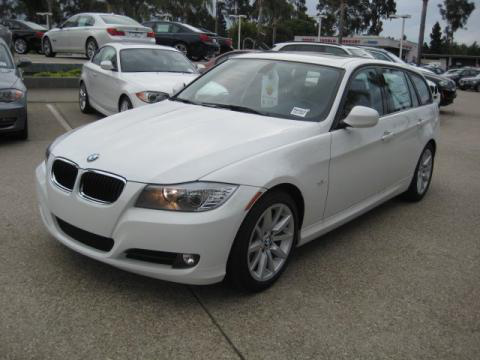

In [117]:
image_path_list = list(data_path.glob("*/*/*.jpg"))
inp_index = int(input("Enter Index of Image : "))
selected_image = image_path_list[inp_index]
img = Image.open(selected_image)

print(f"Random image path: {selected_image}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

In [123]:
query_img = data_transform(img)
query_img

extractor = ImageFeatureExtractor()
similar_images = extractor.find_similar_images(img, dataloader)

# Print the paths of the 10 most similar images

'''
{'/content/drive/MyDrive/Datasets/Stanford_cars/cars_train/train_subset/05274.jpg': 0.8744604587554932, '/content/drive/MyDrive/Datasets/Stanford_cars/cars_train/train_subset/05578.jpg': 0.8585188388824463, '/content/drive/MyDrive/Datasets/Stanford_cars/cars_train/train_subset/04389.jpg': 0.857569694519043, '/content/drive/MyDrive/Datasets/Stanford_cars/cars_train/train_subset/04135.jpg': 0.8542807102203369, '/content/drive/MyDrive/Datasets/Stanford_cars/cars_train/train_subset/06955.jpg': 0.8515975475311279, '/content/drive/MyDrive/Datasets/Stanford_cars/cars_train/train_subset/02692.jpg': 0.8514695763587952, '/content/drive/MyDrive/Datasets/Stanford_cars/cars_train/train_subset/07833.jpg': 0.8513762950897217, '/content/drive/MyDrive/Datasets/Stanford_cars/cars_train/train_subset/02660.jpg': 0.8508657217025757, '/content/drive/MyDrive/Datasets/Stanford_cars/cars_train/train_subset/04694.jpg': 0.8500855565071106, '/content/drive/MyDrive/Datasets/Stanford_cars/cars_train/train_subset/02754.jpg': 0.8499605655670166}
'''
print(similar_images)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


{'/content/drive/MyDrive/Datasets/Stanford_cars/cars_train/train_subset/03503.jpg': 0.8444786071777344, '/content/drive/MyDrive/Datasets/Stanford_cars/cars_train/train_subset/06222.jpg': 0.8423157930374146, '/content/drive/MyDrive/Datasets/Stanford_cars/cars_train/train_subset/07633.jpg': 0.8402639031410217, '/content/drive/MyDrive/Datasets/Stanford_cars/cars_train/train_subset/05007.jpg': 0.8395158052444458, '/content/drive/MyDrive/Datasets/Stanford_cars/cars_train/train_subset/00918.jpg': 0.8382261991500854, '/content/drive/MyDrive/Datasets/Stanford_cars/cars_train/train_subset/01823.jpg': 0.8381413817405701, '/content/drive/MyDrive/Datasets/Stanford_cars/cars_train/train_subset/05437.jpg': 0.8362839221954346, '/content/drive/MyDrive/Datasets/Stanford_cars/cars_train/train_subset/05292.jpg': 0.834162175655365, '/content/drive/MyDrive/Datasets/Stanford_cars/cars_train/train_subset/04530.jpg': 0.834159255027771, '/content/drive/MyDrive/Datasets/Stanford_cars/cars_train/train_subset/048

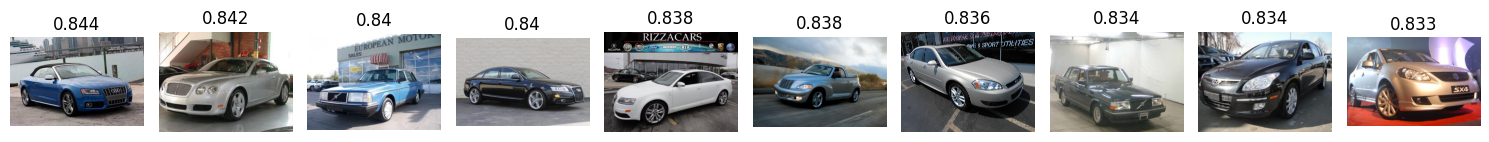

['Audi S5 Coupe 2012',
 'Bentley Continental Flying Spur Sedan 2007',
 'Volvo XC90 SUV 2007',
 'Audi S5 Convertible 2012',
 'Audi S5 Convertible 2012',
 'Daewoo Nubira Wagon 2002',
 'Chevrolet Tahoe Hybrid SUV 2012',
 'Volvo XC90 SUV 2007',
 'Hyundai Azera Sedan 2012',
 'Tesla Model S Sedan 2012']

In [124]:
def pathGen(inp_path):
  op_indices = []
  for i in inp_path:
    op_indices.append(i[70:])
  return op_indices

out_img_idx = pathGen(list(similar_images.keys()))

def plot_imgs(image_paths,scores, n=len(similar_images), seed=None):

    fig, axs = plt.subplots(nrows=1, ncols=n, figsize=(15, 7))
    for i, path in enumerate(image_paths):
        with Image.open(path) as img:
            axs[i].imshow(img)
            axs[i].set_title(f"{round(scores[i],3)}")
            axs[i].axis('off')

    plt.tight_layout()
    plt.show()


plot_imgs(list(similar_images.keys()),list(similar_images.values()))

def out_labels_gen(locs):
  out_labels = []
  for i in locs:
    s = str(anno_df[train_labels.loc[train_labels['image'] == i]['labels'].values[0]])
    start_pos = s.find('[')
    end_pos = s.find(']')
    val = s[start_pos + 1:end_pos]
    out_labels.append(val)

  return out_labels

out_labels_gen(out_img_idx)